# Amadeus Sample Data

## Import Packages

In [1]:
!pip install python-dotenv

In [2]:
import requests
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from collections import Counter
from dotenv import load_dotenv

load_dotenv()

True

## Authenticate

In [3]:
def get_amadeus_token(client_id, client_secret):
    url = "https://test.api.amadeus.com/v1/security/oauth2/token"
    headers = {'Content-Type': 'application/x-www-form-urlencoded'}
    body = {
        'grant_type': 'client_credentials',
        'client_id': client_id,
        'client_secret': client_secret
    }
    
    response = requests.post(url, headers=headers, data=body)
    
    if response.status_code == 200:
        token = response.json()['access_token']
        print("Successfully authenticated.")
        return token
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

client_id = os.environ.get('CLIENT_ID')
client_secret = os.environ.get('CLIENT_SECRET')

token = get_amadeus_token(client_id, client_secret)

Successfully authenticated.


## Collect Data

In [5]:
# Run this block sparingly

# Function to collect flight data
def collect_flight_data(token, origin, destination, departure_date):
    url = f"https://test.api.amadeus.com/v2/shopping/flight-offers?originLocationCode={origin}&destinationLocationCode={destination}&departureDate={departure_date}&adults=1"
    headers = {'Authorization': f'Bearer {token}'}
    
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        data = response.json()['data']
        return data
    else:
        print(f"Error fetching flight data: {response.status_code}, {response.text}")
        return []

# Example: Collect flight data for a few destinations
destinations = ['TYO', 'PAR', 'BKK']  # Tokyo, Paris, Bangkok
flight_data = []

for dest in destinations:
    flights = collect_flight_data(token, 'NYC', dest, '2024-11-01')
    flight_data.extend(flights)

# Display sample data
print(json.dumps(flight_data[:2], indent=2))

[
  {
    "type": "flight-offer",
    "id": "1",
    "source": "GDS",
    "instantTicketingRequired": false,
    "nonHomogeneous": false,
    "oneWay": false,
    "isUpsellOffer": false,
    "lastTicketingDate": "2024-10-21",
    "lastTicketingDateTime": "2024-10-21",
    "numberOfBookableSeats": 9,
    "itineraries": [
      {
        "duration": "PT17H20M",
        "segments": [
          {
            "departure": {
              "iataCode": "LGA",
              "terminal": "B",
              "at": "2024-11-01T11:25:00"
            },
            "arrival": {
              "iataCode": "ORD",
              "terminal": "1",
              "at": "2024-11-01T13:04:00"
            },
            "carrierCode": "UA",
            "number": "2091",
            "aircraft": {
              "code": "319"
            },
            "operating": {
              "carrierCode": "UA"
            },
            "duration": "PT2H39M",
            "id": "64",
            "numberOfStops": 0,
           

In [6]:
# Run this block sparingly

# From Amadeus: This API is currently experiencing an outage due to an internal update. We will inform you as soon as the issue is resolved.

# Function to collect Points of Interest (POI) data
def collect_poi_data(token, latitude, longitude):
    url = f"https://test.api.amadeus.com/v1/reference-data/locations/pois?latitude={latitude}&longitude={longitude}&radius=5"
    headers = {'Authorization': f'Bearer {token}'}
    
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        data = response.json()['data']
        return data
    else:
        print(f"Error fetching POI data: {response.status_code}, {response.text}")
        return []

# Example: Collect POI data for Tokyo (latitude: 35.6762, longitude: 139.6503)
poi_data = collect_poi_data(token, 35.6762, 139.6503)

# Display sample data
print(json.dumps(poi_data[:2], indent=2))

Error fetching POI data: 500, 
            {
                "errors": [
                        {
                            "code": 38189,
                            "title": "Internal error",
                            "detail": "An internal error occurred, please contact your administrator",
                            "status": 500
                        }
                ]
            }
        
[]


In [8]:
# Run this block sparingly

# Function to collect hotel data by city code
def collect_hotel_data_by_city(token, city_code, radius=None):
    url = f"https://test.api.amadeus.com/v1/reference-data/locations/hotels/by-city?cityCode={city_code}"
    
    if radius:
        url += f"&radius={radius}"
    
    headers = {'Authorization': f'Bearer {token}'}
    
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        data = response.json()['data']
        return data
    else:
        print(f"Error fetching hotel data: {response.status_code}, {response.text}")
        return []

# Example: Collect hotel data for Tokyo (IATA city code: TYO)
city_code = 'TYO'  # Tokyo
# radius = 50  # Optional: search within a 50 km radius

hotel_data = collect_hotel_data_by_city(token, city_code)
# hotel_data = collect_hotel_data_by_city(token, city_code, radius)

# Display sample data
print(json.dumps(hotel_data[:2], indent=2))

[
  {
    "chainCode": "AZ",
    "iataCode": "TYO",
    "dupeId": 700085152,
    "name": "SOMERSET ROPPONGI",
    "hotelId": "AZTYO153",
    "geoCode": {
      "latitude": 35.66478,
      "longitude": 139.73583
    },
    "address": {
      "countryCode": "JP"
    },
    "lastUpdate": "2023-06-15T10:09:54"
  },
  {
    "chainCode": "BC",
    "iataCode": "TYO",
    "dupeId": 700077230,
    "name": "NEW OTANI MAKUHARI",
    "hotelId": "BCTYOMAK",
    "geoCode": {
      "latitude": 35.64551,
      "longitude": 140.03821
    },
    "address": {
      "countryCode": "JP"
    },
    "lastUpdate": "2023-06-15T10:21:26"
  }
]


In [9]:
# Parse flight data into a DataFrame
def parse_flight_data(flight_data):
    flights_list = []
    for flight in flight_data:
        price = flight['price']['total']
        origin = flight['itineraries'][0]['segments'][0]['departure']['iataCode']
        destination = flight['itineraries'][0]['segments'][0]['arrival']['iataCode']
        duration = flight['itineraries'][0]['duration']
        stopovers = len(flight['itineraries'][0]['segments']) - 1
        flights_list.append([origin, destination, price, duration, stopovers])
    
    # Create a DataFrame
    df_flights = pd.DataFrame(flights_list, columns=['Origin', 'Destination', 'Price', 'Duration', 'Stopovers'])
    return df_flights

# Convert flight data to a DataFrame
df_flights = parse_flight_data(flight_data)
df_flights.head()

,Origin,Destination,Price,Duration,Stopovers
0,LGA,ORD,414.80,PT17H20M,1
1,LGA,IAD,414.80,PT17H25M,1
2,LGA,ORD,414.80,PT18H20M,1
3,LGA,DEN,414.80,PT19H19M,1
4,LGA,IAH,414.80,PT30H11M,1


In [10]:
# Parse hotel data into a DataFrame
def parse_hotel_data(hotel_data):
    hotels_list = []
    for hotel in hotel_data:
        hotel_name = hotel['name']
        hotel_id = hotel['hotelId']
        hotel_lat = hotel['geoCode']['latitude']
        hotel_lon = hotel['geoCode']['longitude']
        hotels_list.append([hotel_name, hotel_id, hotel_lat, hotel_lon])
    
    # Create a DataFrame
    df_hotels = pd.DataFrame(hotels_list, columns=['Name', 'Hotel ID', 'Latitude', 'Longitude'])
    return df_hotels

# Convert hotel data to a DataFrame
df_hotels = parse_hotel_data(hotel_data)
df_hotels.head()

,Name,Hotel ID,Latitude,Longitude
0,SOMERSET ROPPONGI,AZTYO153,35.66478,139.73583
1,NEW OTANI MAKUHARI,BCTYOMAK,35.64551,140.03821
2,NEW OTANI TOKYO THE MAIN,BCTYONOH,35.68087,139.73401
3,BEST WESTERN SHINJUKU ASTINA,BWTYO510,35.69442,139.70428
4,BEST WESTERN TOKYO NISHIKASAI,BWTYO529,35.66328,139.86027


## Save Data to CSV

In [ ]:
# Save flight data to a CSV file
df_flights.to_csv('flight_data.csv', index=False)

# Save POI data to a CSV (if structured)
df_poi = pd.DataFrame(poi_data)
df_poi.to_csv('poi_data.csv', index=False)

# Save hotel data to a CSV file
df_hotels.to_csv('hotel_data.csv', index=False)

## Data Exploration & Preparation

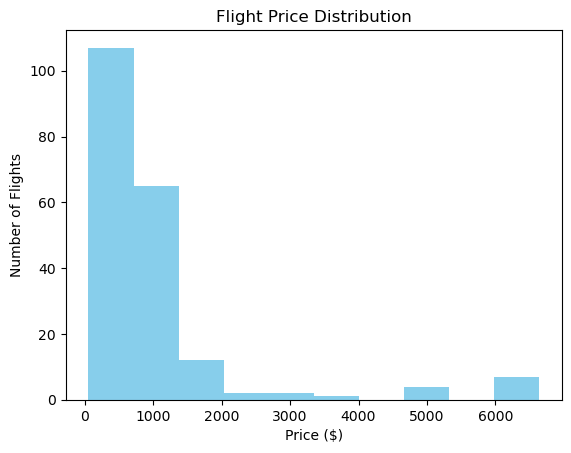

In [11]:
# Plot flight price distribution
plt.hist(df_flights['Price'].astype(float), bins=10, color='skyblue')
plt.title('Flight Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Number of Flights')
plt.show()

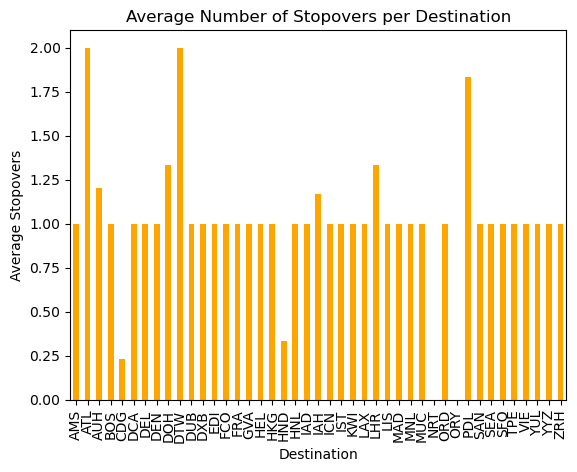

In [12]:
# Bar chart for stopovers per destination
df_flights.groupby('Destination')['Stopovers'].mean().plot(kind='bar', color='orange')
plt.title('Average Number of Stopovers per Destination')
plt.ylabel('Average Stopovers')
plt.show()

In [ ]:
# Parse POI data to count categories
def count_poi_categories(poi_data):
    categories = []
    for poi in poi_data:
        categories.append(poi['category'])
    
    category_counts = Counter(categories)
    return category_counts

# Count the categories
category_counts = count_poi_categories(poi_data)

# Display the category counts
print(category_counts)

In [ ]:
# Plot the pie chart for POI categories
def plot_poi_pie_chart(category_counts):
    labels = category_counts.keys()
    sizes = category_counts.values()
    
    # Create pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    
    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.axis('equal')
    plt.title('Distribution of Points of Interest Categories')
    plt.show()

# Plot the pie chart
plot_poi_pie_chart(category_counts)